In [2]:
import torch 
torch.manual_seed(1)
import sys
sys.path.append('..')

from targets import Target
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

In [6]:
from models_nf import MixedModelDensityEstimator,DIFDensityEstimatorLayer,RealNVPDensityEstimatorLayer

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
N = 256
orange = np.ones((N, 4))
orange[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
orange[:, 1] = np.geomspace(165 / 256, 1, N)  # G = 165
orange[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
orange_cmap = ListedColormap(orange[::-1])

orange_color = "#FFA500"

red = np.ones((N, 4))
red[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
red[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
red[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
red_cmap = ListedColormap(red[::-1])

red_color = "#FF0000"

blue = np.ones((N, 4))
blue[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
blue[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
blue[:, 2] = np.geomspace(255 / 256, 1, N)  # B = 255
blue_cmap = ListedColormap(blue[::-1])

blue_color = "#0000FF"

green = np.ones((N, 4))
green[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
green[:, 1] = np.geomspace(128 / 256, 1, N)  # G = 128
green[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 128
green_cmap = ListedColormap(green[::-1])

green_color = "#008000"

pink = np.ones((N, 4))
pink[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
pink[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
pink[:, 2] = np.geomspace(211 / 256, 1, N)  # B = 211
pink_cmap = ListedColormap(pink[::-1])

pink_color = "#FF00D3"

purple = np.ones((N, 4))
purple[:, 0] = np.geomspace(51 / 256, 1, N)  # R = 102
purple[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
purple[:, 2] = np.geomspace(51 / 256, 1, N)  # B = 102
purple_cmap = ListedColormap(purple[::-1])

purple_color = "#660066"

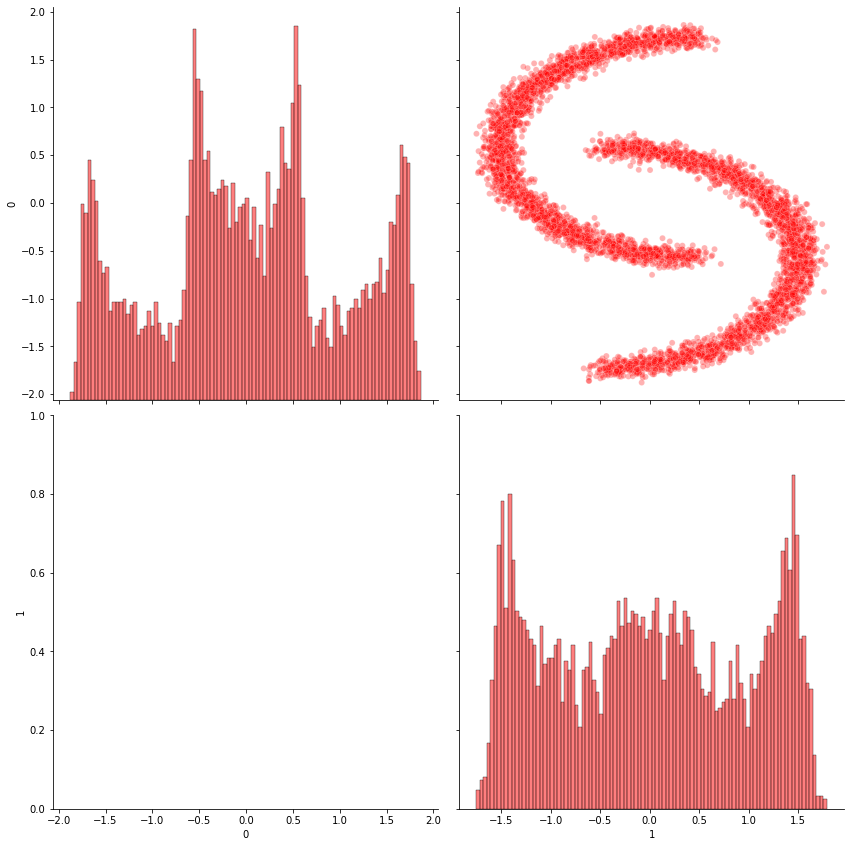

In [13]:
example =  "Moons"
num_samples = 50000
target =Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

In [8]:
num_samples = target_samples.shape[0]
epochs =3000
batch_size = int(num_samples/5)
structure = [[RealNVPDensityEstimatorLayer,[80,80,80]],[RealNVPDensityEstimatorLayer,[80,80,80]],[RealNVPDensityEstimatorLayer,[80,80,80]],[RealNVPDensityEstimatorLayer,[80,80,80]]]
realnvp = MixedModelDensityEstimator(target_samples,structure)
realnvp.train(epochs, batch_size)

 24%|██████████████████████████████▉                                                                                                | 732/3000 [28:29<1:28:16,  2.34s/it, loss = 1.205397]


KeyboardInterrupt: 

Text(0.5, 1.0, '$Q$ Density')

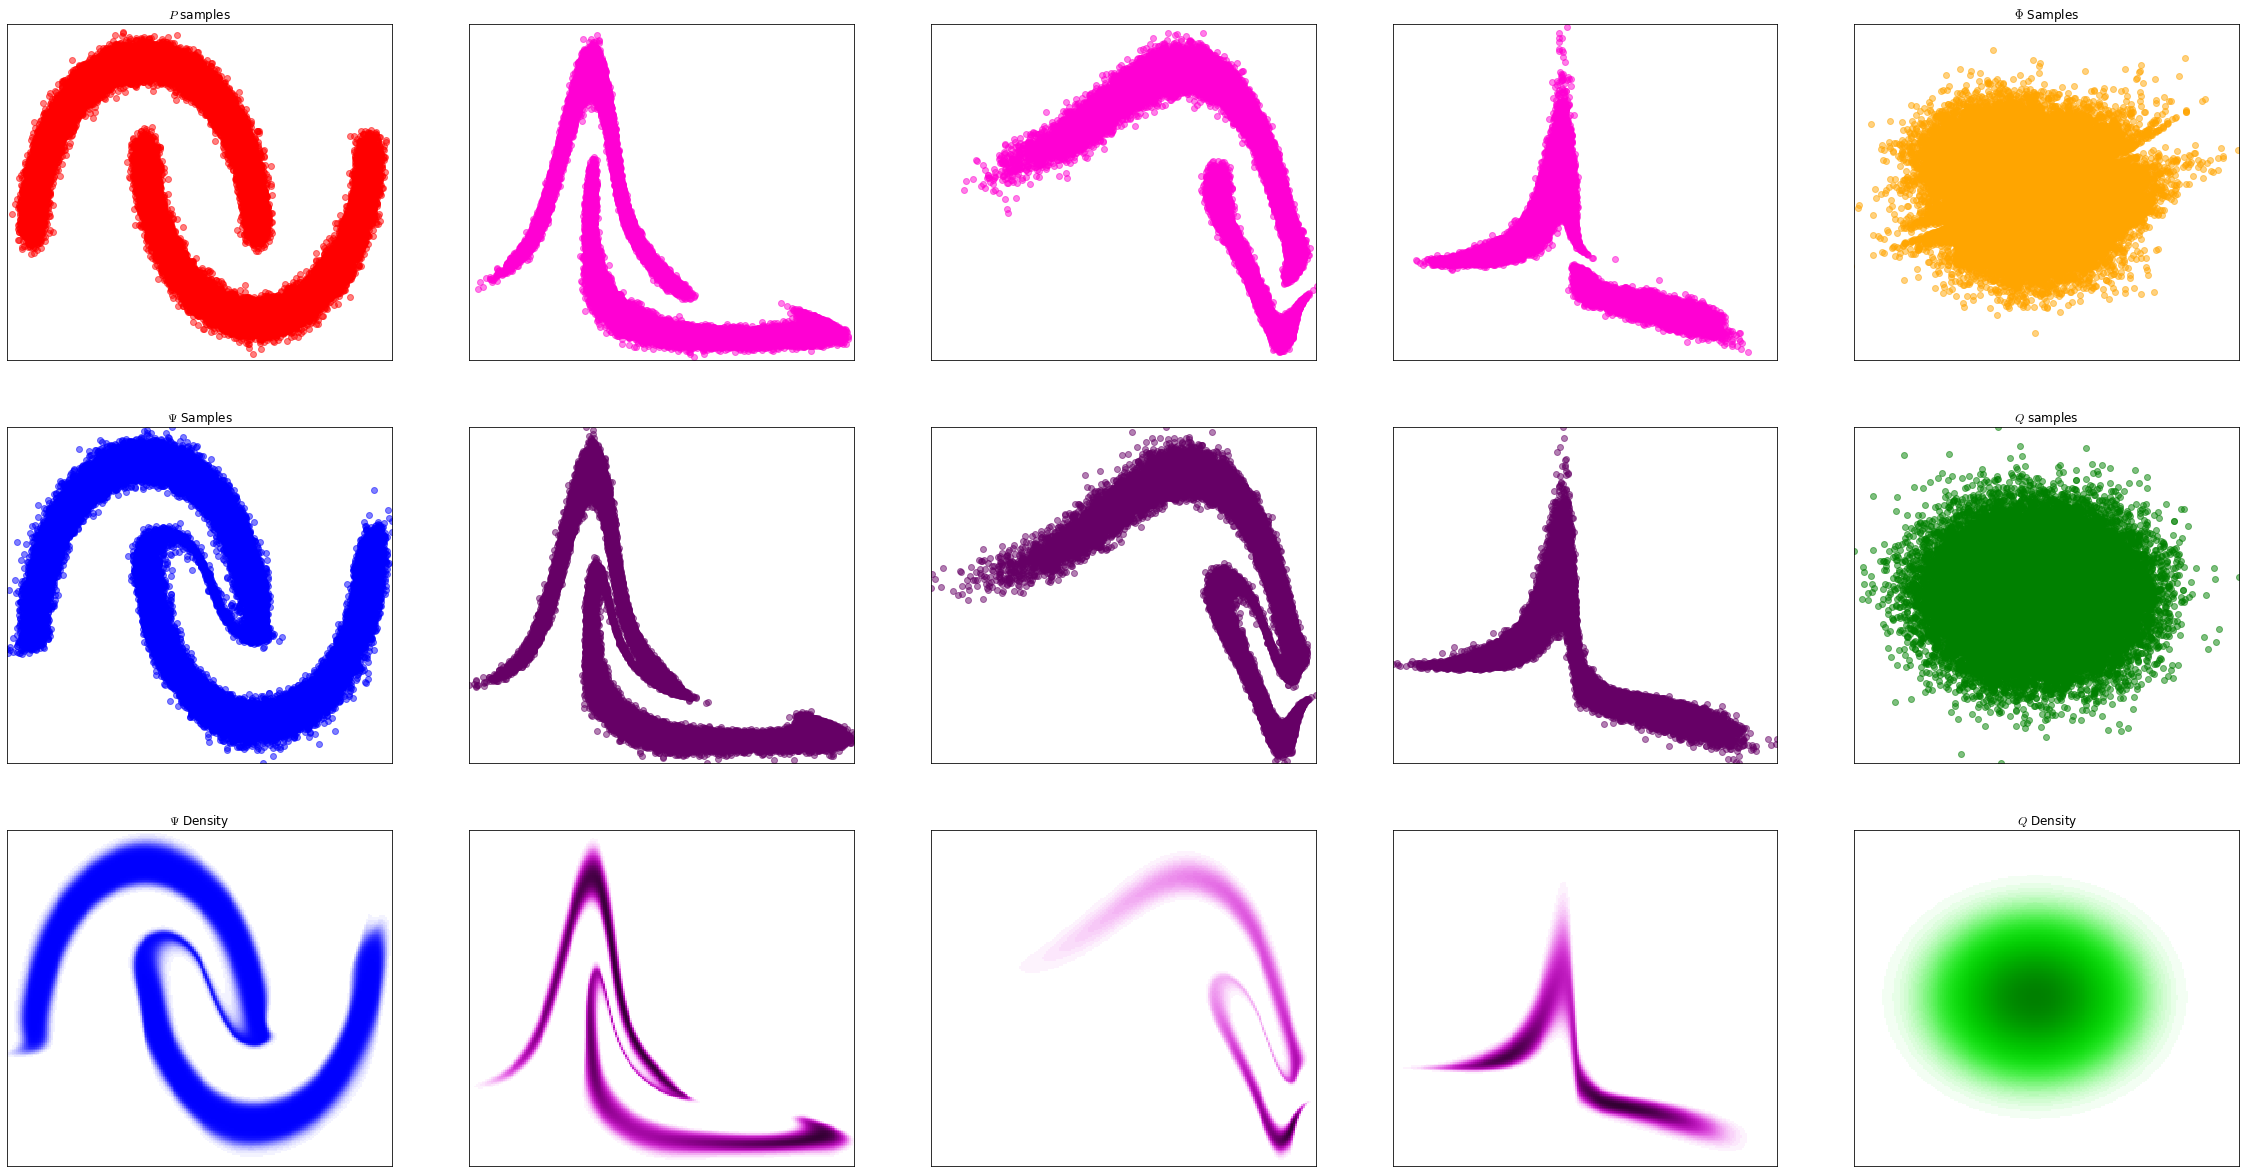

In [14]:
###Visualize Density Estimation Flow dimension >1###

flow_to_visualize = realnvp
delta = 200
with torch.no_grad():
    samples = flow_to_visualize.reference.sample(num_samples)
    backward_samples = [samples]
    grid = torch.cartesian_prod(torch.linspace(torch.min(samples[:,0]).item(), torch.max(samples[:,0]).item(),delta),torch.linspace(torch.min(samples[:,1]).item(), torch.max(samples[:,1]).item(),delta))
    grid = torch.cat((grid, torch.mean(samples[:,2:], dim = 0)*torch.ones(grid.shape[0], flow_to_visualize.p-2)), dim = -1)
    density = torch.exp(flow_to_visualize.reference.log_density(grid)).reshape(delta,delta).T.detach()
    backward_density = [density]
    x_range = [[torch.min(samples[:,0]).item(), torch.max(samples[:,0]).item()]]
    y_range = [[torch.min(samples[:, 1]).item(), torch.max(samples[:, 1]).item()]]
    for i in range(flow_to_visualize.N - 1, -1, -1):
        samples = flow_to_visualize.model[i].sample_backward(backward_samples[0])
        backward_samples.insert(0, samples)
        grid = torch.cartesian_prod(torch.linspace(torch.min(samples[:, 0]).item(), torch.max(samples[:, 0]).item(), delta),torch.linspace(torch.min(samples[:, 1]).item(), torch.max(samples[:, 1]).item(), delta))
        grid = torch.cat((grid, torch.zeros(grid.shape[0], flow_to_visualize.p - 2)), dim=-1)
        density = torch.exp(flow_to_visualize.model[i].log_psi(grid)).reshape(delta, delta).T.detach()
        backward_density.insert(0, density)
        x_range.insert(0,[torch.min(samples[:,0]).item(), torch.max(samples[:,0]).item()])
        y_range.insert(0,[torch.min(samples[:, 1]).item(), torch.max(samples[:, 1]).item()])

with torch.no_grad():
    forward_samples = [flow_to_visualize.target_samples[:num_samples]]
    for i in range(flow_to_visualize.N):
        forward_samples.append(flow_to_visualize.model[i].sample_forward(forward_samples[-1]))

fig = plt.figure(figsize=((flow_to_visualize.N + 1) * 8, 3 * 7))
ax = fig.add_subplot(3, flow_to_visualize.N + 1, 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(forward_samples[0][:, 0], forward_samples[0][:, 1], alpha=0.5, color=red_color)
ax.set_title(r'$P$ samples')
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
for i in range(1, flow_to_visualize.N):
    ax = fig.add_subplot(3, flow_to_visualize.N + 1, i + 1)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.scatter(forward_samples[i][:, 0], forward_samples[i][:, 1], alpha=0.5,
                color=pink_color)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
ax = fig.add_subplot(3, flow_to_visualize.N + 1, flow_to_visualize.N + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(forward_samples[-1][:, 0], forward_samples[-1][:, 1] alpha=0.5,
            color=orange_color)
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$\Phi$ Samples')

ax = fig.add_subplot(3, flow_to_visualize.N + 1, flow_to_visualize.N + 1 + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(backward_samples[0][:, 0], backward_samples[0][:, 1], alpha=0.5, color=blue_color)
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$\Psi$ Samples')
ax = fig.add_subplot(3, flow_to_visualize.N + 1, 2*(flow_to_visualize.N + 1) + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[0][:, 0]).item(), torch.max(backward_samples[0][:, 0]).item(), 200),torch.linspace(torch.min(backward_samples[0][:, 1]).item(), torch.max(backward_samples[0][:, 1]).item(), 200), backward_density[0],cmap = blue_cmap,shading='auto' )
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$\Psi$ Density')
for i in range(1, flow_to_visualize.N):
    ax = fig.add_subplot(3, flow_to_visualize.N + 1, flow_to_visualize.N + 1 + i + 1)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.scatter(backward_samples[i][:, 0], backward_samples[i][:, 1], alpha=0.5,
                color=purple_color)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
    ax = fig.add_subplot(3, flow_to_visualize.N + 1, 2 * (flow_to_visualize.N + 1) + i + 1)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
    ax.pcolormesh(torch.linspace(torch.min(backward_samples[i][:, 0]).item(), torch.max(backward_samples[i][:, 0]).item(), 200),torch.linspace(torch.min(backward_samples[i][:, 1]).item(), torch.max(backward_samples[i][:, 1]).item(), 200), backward_density[i], cmap=purple_cmap,shading='auto')

ax = fig.add_subplot(3, flow_to_visualize.N + 1, flow_to_visualize.N + 1 + flow_to_visualize.N + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(backward_samples[-1][:, 0], backward_samples[-1][:, 1], alpha=0.5,
            color=green_color)
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$Q$ samples')
ax = fig.add_subplot(3, flow_to_visualize.N + 1, 2*(flow_to_visualize.N + 1) + flow_to_visualize.N + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[-1][:, 0]).item(), torch.max(backward_samples[-1][:, 0]).item(), 200),torch.linspace(torch.min(backward_samples[-1][:, 1]).item(), torch.max(backward_samples[-1][:, 1]).item(), 200), backward_density[-1], cmap=green_cmap,shading='auto')
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r"$Q$ Density")

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

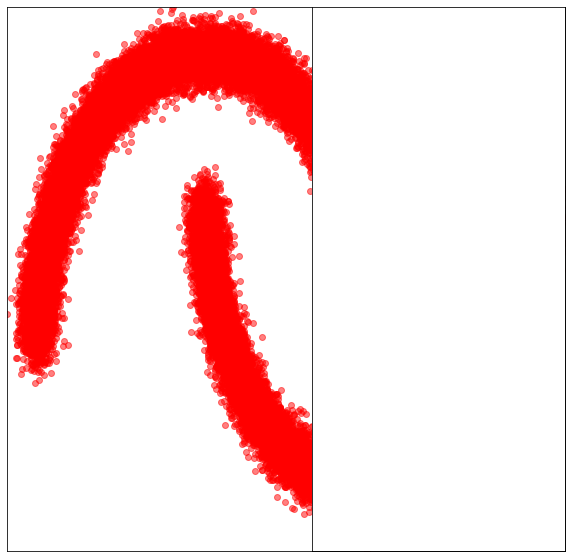

<Figure size 720x720 with 0 Axes>

In [43]:
### Visualize only target samples and model density ###
model_to_visualize = realnvp
delta = 500
with torch.no_grad():
    ax = fig.add_subplot(1,2,1)
    fig = plt.figure(figsize = (10,10))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.scatter(model_to_visualize.target_samples[:,0],model_to_visualize.target_samples[:,1], color = red_color, alpha = 0.5)
    x_range = [torch.min(model_to_visualize.target_samples[:,0]).item(), torch.max(model_to_visualize.target_samples[:,0]).item()]
    y_range = [torch.min(model_to_visualize.target_samples[:, 1]).item(), torch.max(model_to_visualize.target_samples[:, 1]).item()]
    grid = torch.cartesian_prod(torch.linspace(x_range[0], x_range[1], delta), torch.linspace(y_range[0], y_range[1], delta))
    density = torch.exp(model_to_visualize.log_density(grid))
    plt.figure(figsize = (10,10))
    plt = fig.add_subplot(1,2,2)
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.pcolormesh(torch.linspace(x_range[0], x_range[1], delta),torch.linspace(y_range[0], y_range[1], delta),density.reshape(delta, delta).T, cmap = blue_cmap)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:24<00:00, 11.33it/s, loss = 1.1362411975860596]


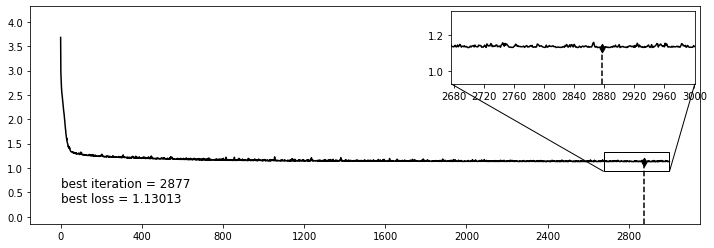

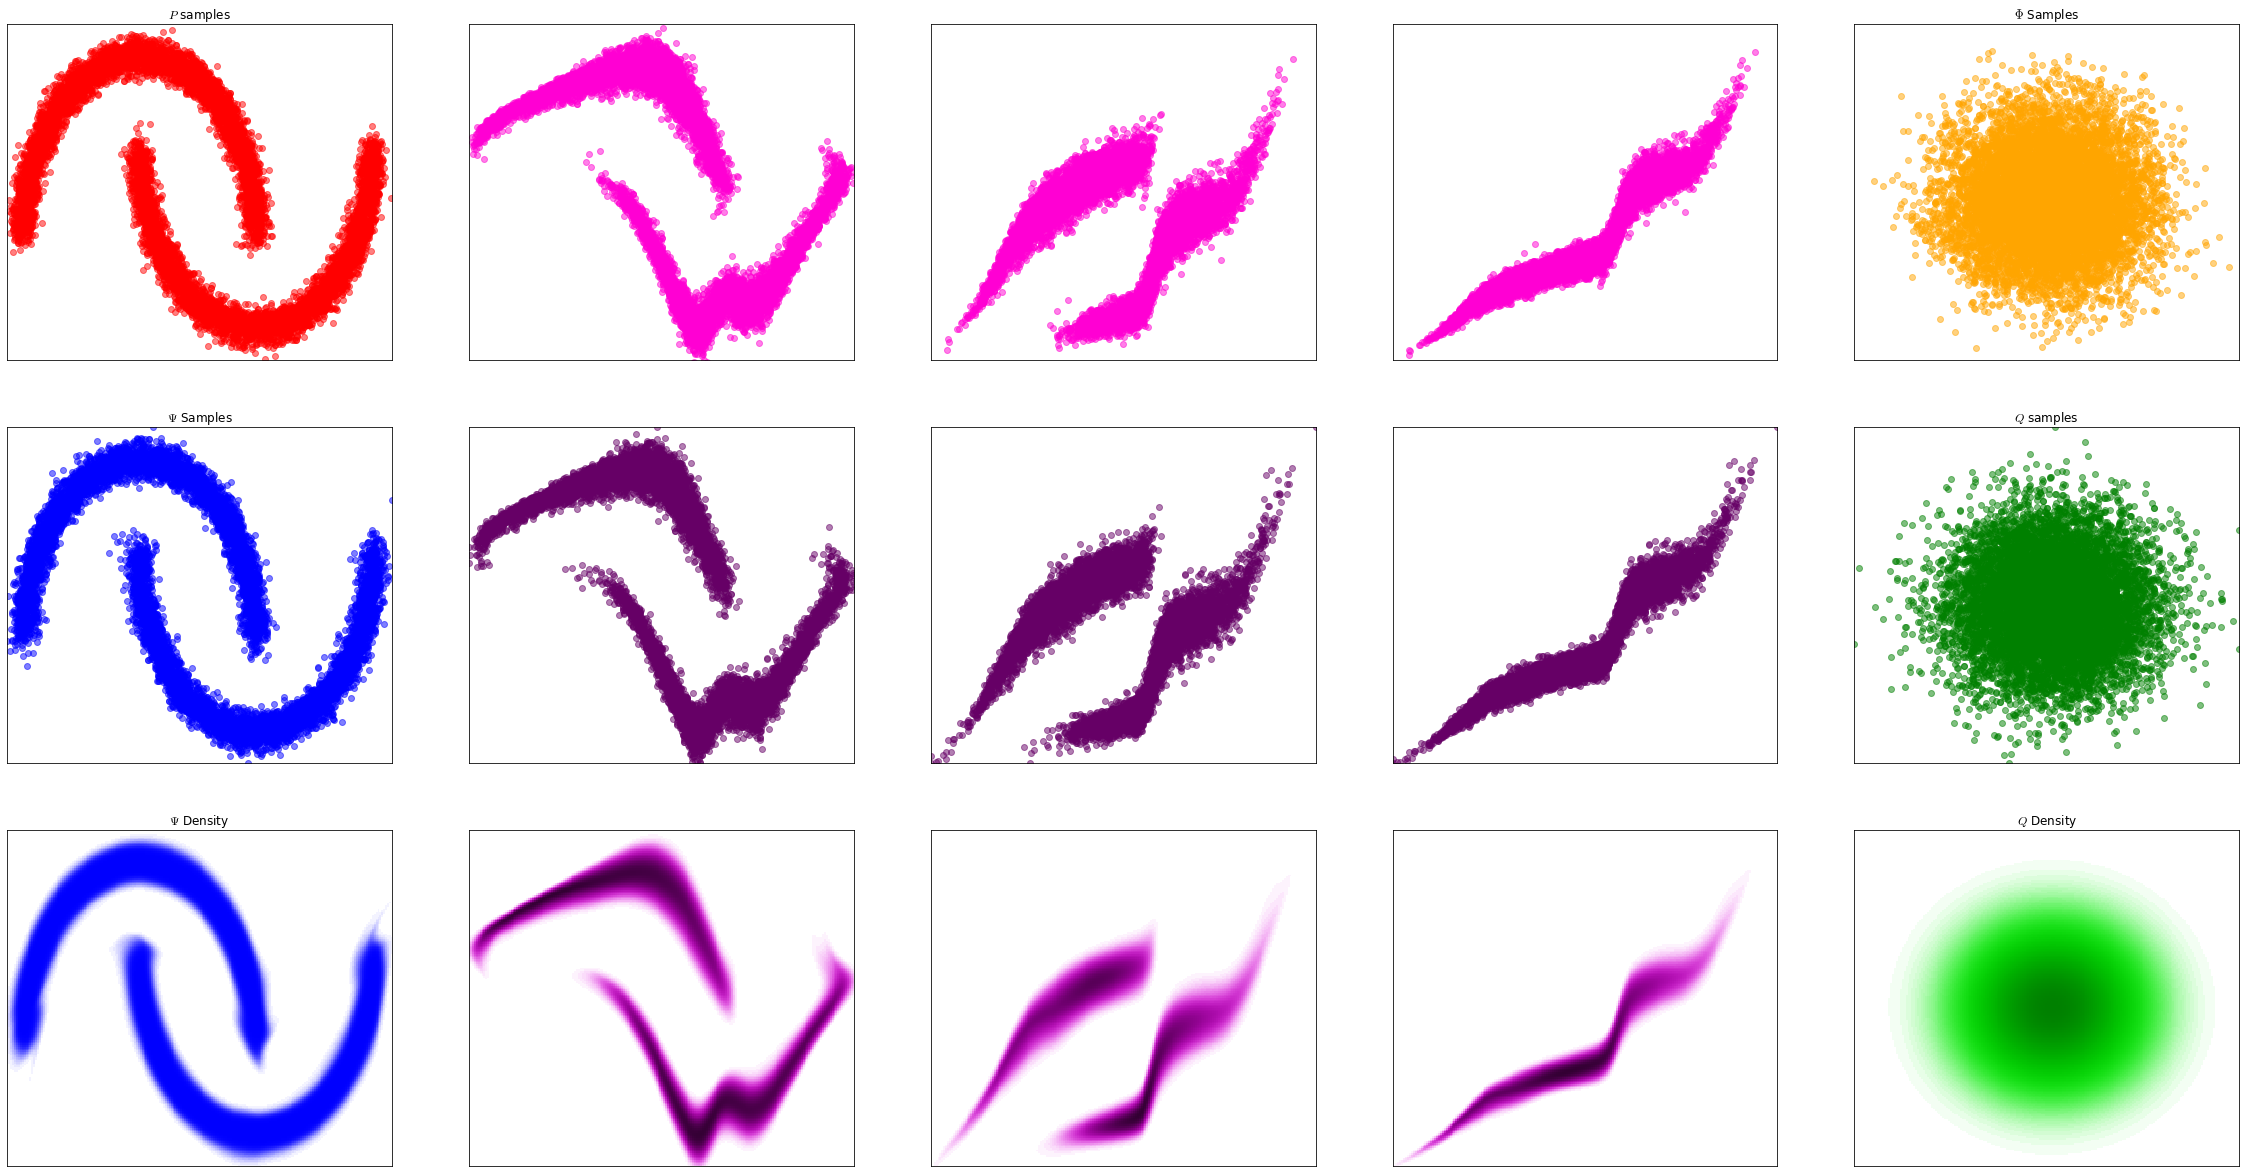

In [5]:
num_samples = target_samples.shape[0]
epochs =3000
batch_size = int(num_samples/5)
structure = [[RealNVPDensityEstimatorLayer,[80,80,80]],[RealNVPDensityEstimatorLayer,[80,80,80]],[DIFDensityEstimatorLayer,2],[RealNVPDensityEstimatorLayer,[80,80,80]]]
realnvp_dif = MixedModelDensityEstimator(target_samples,structure)
realnvp_dif.train(epochs, batch_size, visual = True)
realnvp_dif.model_visual(num_samples=int(num_samples/5), flow = True)